In [2]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import sys
import os
import logging
import galsim
import cmath as cm
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import WMAP9 as cosmo
import scipy
import scipy.integrate 
import tensorflow.keras

In [3]:
N_exposures = 100
pixel_scale_lsst = 0.2 # arcseconds # LSST Science book
pixel_scale_euclid_nir = 0.3 # arcseconds # Euclid Science book
pixel_scale_euclid_vis = 0.1

sky_level_lsst_u = (2.512 **(26.50-22.95)) * N_exposures # in e-.s-1.arcsec_2
sky_level_lsst_g = (2.512 **(28.30-22.24)) * N_exposures # in e-.s-1.arcsec_2
sky_level_lsst_r = (2.512 **(28.13-21.20)) * N_exposures # in e-.s-1.arcsec_2
sky_level_lsst_i = (2.512 **(27.79-20.47)) * N_exposures # in e-.s-1.arcsec_2
sky_level_lsst_z = (2.512 **(27.40-19.60)) * N_exposures # in e-.s-1.arcsec_2
sky_level_lsst_y = (2.512 **(26.58-18.63)) * N_exposures # in e-.s-1.arcsec_2
sky_level_pixel_lsst = [int((sky_level_lsst_u * 15 * pixel_scale_lsst**2)),
                       int((sky_level_lsst_g* 15 * pixel_scale_lsst**2)),
                       int((sky_level_lsst_r* 15 * pixel_scale_lsst**2)),
                       int((sky_level_lsst_i* 15 * pixel_scale_lsst**2)),
                       int((sky_level_lsst_z* 15 * pixel_scale_lsst**2)),
                       int((sky_level_lsst_y* 15 * pixel_scale_lsst**2))]# in e-/pixel/15s


In [4]:
sky_level_pixel_lsst

[1578, 15931, 35504, 50850, 79123, 90846]

In [5]:
for i in range (4,10):
    print(sky_level_pixel_lsst[i-4])

1578
15931
35504
50850
79123
90846


In [6]:
import random

In [43]:
# Generation function
def Gal_generator_noisy(cosmos_cat):
    cosmos_cat = cosmos_cat
    count = 0
    galaxy = np.zeros((10))
    while (galaxy.all() == 0):
        try:
            path, filename = os.path.split('__file__')    
            datapath = galsim.meta_data.share_dir
            datapath2 = os.path.abspath(os.path.join(path,'/sps/lsst/users/barcelin/EUCLID_Filters/'))

            # initialize (pseudo-)random number generator
            random_seed = 1234567
            rng = galsim.BaseDeviate(random_seed+1)

                    # read in the Euclid NIR filters
            filter_names_euclid_nir = 'HJY'
            filter_names_euclid_vis = 'V'

            # read in the LSST filters
            filter_names_lsst = 'ugrizy'
            filters = {}


            for filter_name in filter_names_euclid_nir:
                filter_filename = os.path.join(datapath2, 'Euclid_NISP0.{0}.dat'.format(filter_name))
                filters[filter_name] = galsim.Bandpass(filter_filename, wave_type='Angstrom')
                filters[filter_name] = filters[filter_name].thin(rel_err=1e-4)

            for filter_name in filter_names_euclid_vis:
                filter_filename = os.path.join(datapath2, 'Euclid_VIS.dat'.format(filter_name))
                filters[filter_name] = galsim.Bandpass(filter_filename, wave_type='Angstrom')
                filters[filter_name] = filters[filter_name].thin(rel_err=1e-4)

            for filter_name in filter_names_lsst:
                filter_filename = os.path.join(datapath, 'bandpasses/LSST_{0}.dat'.format(filter_name))
                filters[filter_name] = galsim.Bandpass(filter_filename, wave_type='nm')
                filters[filter_name] = filters[filter_name].thin(rel_err=1e-4)

            pixel_scale_lsst = 0.2 # arcseconds # LSST Science book
            pixel_scale_euclid_nir = 0.3 # arcseconds # Euclid Science book
            pixel_scale_euclid_vis = 0.1 # arcseconds # Euclid Science book

           # Chromatic bulge+disk galaxy
            # On prend la distribution de galaxies en fonction du redshift du Science Book de LSST
            i = 25.
            z0 = (0.0417*i)-0.744
            zl=np.arange(0.001,5,0.01)

            p_unnormed = lambda z : ((1/(2*z0))*((z/z0)**2)*np.exp(-z/z0))
            p_normalization = scipy.integrate.quad(p_unnormed, 0., np.inf)[0]
            p = lambda z : p_unnormed(z) / p_normalization

            from scipy import stats
            class LSST_redshift_distribution(stats.rv_continuous):
                def __init__(self):
                    super(LSST_redshift_distribution, self).__init__()
                    self.a = 0.
                    self.b = 10.
                def _pdf(self, x):
                    return p(x)

            nz = LSST_redshift_distribution()

            redshift = nz.rvs()   

            ############## SHAPE OF THE GALAXY ##################
            ud = galsim.UniformDeviate()
            
            ind = random.randint(0,cosmos_cat.nobjects)
            
            print(ind)
            
            gal = cosmos_cat.makeGalaxy(ind, gal_type='parametric', chromatic=True, noise_pad_size = 0)

            gal = gal.rotate(ud() * 360. * galsim.degrees)
            redshift = gal.SED.redshift

            #################### NOISE ###################
            # Poissonian noise according to sky_level
            N_exposures = 100
            
            
            sky_level_lsst_u = (2.512 **(26.50-22.95)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_lsst_g = (2.512 **(28.30-22.24)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_lsst_r = (2.512 **(28.13-21.20)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_lsst_i = (2.512 **(27.79-20.47)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_lsst_z = (2.512 **(27.40-19.60)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_lsst_y = (2.512 **(26.58-18.63)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_pixel_lsst = [int((sky_level_lsst_u * 15 * pixel_scale_lsst**2)),
                                   int((sky_level_lsst_g* 15 * pixel_scale_lsst**2)),
                                   int((sky_level_lsst_r* 15 * pixel_scale_lsst**2)),
                                   int((sky_level_lsst_i* 15 * pixel_scale_lsst**2)),
                                   int((sky_level_lsst_z* 15 * pixel_scale_lsst**2)),
                                   int((sky_level_lsst_y* 15 * pixel_scale_lsst**2))]# in e-/pixel/15s

            # average background level for Euclid observations : 22.35 mAB.arcsec-2 in VIS (Consortium book) ##
            # For NIR bands, a coefficient is applied : it is calculated by comparing magnitudes AB of one point in the
            # sky to the magnitude AB in VIS on this point. The choosen point is (-30;30) in galactic coordinates 
            # (EUCLID and LSST overlap on this point).
            coeff_noise_y = (22.57/21.95)
            coeff_noise_j = (22.53/21.95)
            coeff_noise_h = (21.90/21.95)
            
            sky_level_nir_Y = (2.512 **(24.25-22.35*coeff_noise_y)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_nir_J = (2.512 **(24.29-22.35*coeff_noise_j)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_nir_H = (2.512 **(24.92-22.35*coeff_noise_h)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_vis = (2.512 **(25.58-22.35)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_pixel_nir = [int((sky_level_nir_Y * 1800 * pixel_scale_euclid_nir**2)),
                                   int((sky_level_nir_J* 1800 * pixel_scale_euclid_nir**2)),
                                   int((sky_level_nir_H* 1800 * pixel_scale_euclid_nir**2))]# in e-/pixel/1800s
            sky_level_pixel_vis = int((sky_level_vis * 1800 * pixel_scale_euclid_vis**2))# in e-/pixel/1800s


            # 25.94 : zeros point for the makeGalaxy method and normalization: http://galsim-developers.github.io/GalSim/classgalsim_1_1scene_1_1_c_o_s_m_o_s_catalog.html            
            sky_level_cosmos = 10**((25.94-22.35)/2.5)

            
            
            ############ LUMINOSITY ############# 
            # The luminosity is multiplied by the ratio of the noise in the LSST R band and the assumed cosmos noise             
            bdgal_lsst =  (15. * (6.68**2)/((2.4**2)*(1.-0.33**2))) * gal * N_exposures
            bdgal_euclid_nir =  (1800. * ((1.25)**2 - (0.37)**2)/((2.4**2)*(1.-0.33**2))) * gal * N_exposures
            bdgal_euclid_vis =  (1800. * ((1.25)**2 - (0.37)**2)/((2.4**2)*(1.-0.33**2))) * gal * N_exposures         
            
            
            
            ########### PSF #####################
            # convolve with PSF to make final profil : profil from LSST science book and (https://arxiv.org/pdf/0805.2366.pdf)
            mu = -0.43058681997903414
            sigma = 0.3404334041976153
            p_unnormed = lambda x : (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
                               / (x * sigma * np.sqrt(2 * np.pi)))#((1/(2*z0))*((z/z0)**2)*np.exp(-z/z0))
            p_normalization = scipy.integrate.quad(p_unnormed, 0., np.inf)[0]
            p = lambda z : p_unnormed(z) / p_normalization

            from scipy import stats
            class PSF_distribution(stats.rv_continuous):
                def __init__(self):
                    super(PSF_distribution, self).__init__()
                    self.a = 0.
                    self.b = 10.
                def _pdf(self, x):
                    return p(x)

            pdf = PSF_distribution()
            fwhm_lsst = pdf.rvs()

            fwhm_euclid_nir = 0.22 # EUCLID PSF is supposed invariant (no atmosphere) despite the optical and wavelengths variations
            fwhm_euclid_vis = 0.18 # EUCLID PSF is supposed invariant (no atmosphere) despite the optical and wavelengths variations
            beta = 2.5
            PSF_lsst = galsim.Kolmogorov(fwhm=fwhm_lsst)#galsim.Moffat(fwhm=fwhm_lsst, beta=beta)
            PSF_euclid_nir = galsim.Moffat(fwhm=fwhm_euclid_nir, beta=beta)
            PSF_euclid_vis = galsim.Moffat(fwhm=fwhm_euclid_vis, beta=beta)




            ############# SIZE OF STAMPS ################
            # The stamp size of NIR instrument is taken equal to the one of LSST to have a nb of pixels which is 
            # an integer and in the same time the max_stamp_size a power of 2 (works better for FFT)
            # The physical size in NIR instrument is then larger than in the other stamps but the information needed
            # for the VAE and deblender is contained in the stamp.
            phys_stamp_size = 6.4 # Arcsecond
            lsst_stamp_size = int(phys_stamp_size/pixel_scale_lsst) # Nb of pixels
            nir_stamp_size = int(phys_stamp_size/pixel_scale_euclid_nir)+1 # Nb of pixels
            vis_stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis) # Nb of pixels

            max_stamp_size = np.max((lsst_stamp_size,nir_stamp_size,vis_stamp_size))
            
            galaxy_nir_noiseless = np.zeros((3,max_stamp_size,max_stamp_size))
            galaxy_vis_noiseless = np.zeros((1,max_stamp_size,max_stamp_size))
            galaxy_lsst_noiseless = np.zeros((6,max_stamp_size,max_stamp_size))
            galaxy_nir_noisy = np.zeros((3,max_stamp_size,max_stamp_size))
            galaxy_vis_noisy = np.zeros((1,max_stamp_size,max_stamp_size))
            galaxy_lsst_noisy = np.zeros((6,max_stamp_size,max_stamp_size))
            galaxy_noiseless = np.zeros((10,max_stamp_size,max_stamp_size))
            galaxy_noisy = np.zeros((10,max_stamp_size,max_stamp_size))

            i = 0
            for filter_name, filter_ in filters.items(): 
                print("filtre : "+str(i))
                if (i < 3):
                    poissonian_noise_nir = galsim.PoissonNoise(rng, sky_level=sky_level_pixel_nir[i])
                    img = galsim.ImageF(max_stamp_size,max_stamp_size, scale=pixel_scale_euclid_nir)  
                    bdfinal = galsim.Convolve([bdgal_euclid_nir, PSF_euclid_nir])
                    bdfinal.drawImage(filter_, image=img)
                    # Noiseless galaxy
                    galaxy_nir_noiseless[i]= img.array.data
                    galaxy_noiseless[i] = galaxy_nir_noiseless[i]
                    # Noisy galaxy
                    img.addNoise(poissonian_noise_nir)
                    galaxy_nir_noisy[i]= img.array.data
                    galaxy_noisy[i] = galaxy_nir_noisy[i]
                else:
                    if (i==3):
                        poissonian_noise_vis = galsim.PoissonNoise(rng, sky_level=sky_level_pixel_vis)
                        img = galsim.ImageF(max_stamp_size,max_stamp_size, scale=pixel_scale_euclid_vis)  
                        bdfinal = galsim.Convolve([bdgal_euclid_vis, PSF_euclid_vis])
                        bdfinal.drawImage(filter_, image=img)
                        # Noiseless galaxy
                        galaxy_vis_noiseless[3-i]= img.array.data
                        galaxy_noiseless[i] = galaxy_vis_noiseless[3-i]
                        # Noisy galaxy
                        img.addNoise(poissonian_noise_vis)
                        galaxy_vis_noisy[3-i]= img.array.data
                        galaxy_noisy[i] = galaxy_vis_noisy[3-i]
                    else:
        #                print('passage a LSST')
                        poissonian_noise_lsst = galsim.PoissonNoise(rng, sky_level_pixel_lsst[i-4])
                        img = galsim.ImageF(max_stamp_size,max_stamp_size, scale=pixel_scale_lsst)  
                        bdfinal = galsim.Convolve([bdgal_lsst, PSF_lsst])
                        bdfinal.drawImage(filter_, image=img)
                        # Noiseless galaxy
                        galaxy_lsst_noiseless[i-4]= img.array.data
                        galaxy_noiseless[i] = galaxy_lsst_noiseless[i-4]
                        print(np.max(galaxy_noiseless[i]))
                        # Noisy galaxy
                        print("noise = "+str(poissonian_noise_lsst))
                        img.addNoise(poissonian_noise_lsst)
                        galaxy_lsst_noisy[i-4]= img.array.data
                        galaxy_noisy[i]= galaxy_lsst_noisy[i-4]
                        print(np.max(galaxy_noisy[i]))
                i+=1
            return galaxy_noiseless, galaxy_noisy, redshift
        except RuntimeError: 
            count +=1
    print("nb of error : "+(count))
    

    

In [37]:
# Generation function
def Gal_generator_noisy_test_adapted_scale(cosmos_cat):
    cosmos_cat = cosmos_cat
    count = 0
    galaxy = np.zeros((10))
    while (galaxy.all() == 0):
        try:
            path, filename = os.path.split('__file__')    
            datapath = galsim.meta_data.share_dir
            datapath2 = os.path.abspath(os.path.join(path,'/sps/lsst/users/barcelin/EUCLID_Filters/'))

            # initialize (pseudo-)random number generator
            random_seed = 1234567
            rng = galsim.BaseDeviate(random_seed+1)

                    # read in the Euclid NIR filters
            filter_names_euclid_nir = 'HJY'
            filter_names_euclid_vis = 'V'

            # read in the LSST filters
            filter_names_lsst = 'ugrizy'
            filters = {}


            for filter_name in filter_names_euclid_nir:
                filter_filename = os.path.join(datapath2, 'Euclid_NISP0.{0}.dat'.format(filter_name))
                filters[filter_name] = galsim.Bandpass(filter_filename, wave_type='Angstrom')
                filters[filter_name] = filters[filter_name].thin(rel_err=1e-4)

            for filter_name in filter_names_euclid_vis:
                filter_filename = os.path.join(datapath2, 'Euclid_VIS.dat'.format(filter_name))
                filters[filter_name] = galsim.Bandpass(filter_filename, wave_type='Angstrom')
                filters[filter_name] = filters[filter_name].thin(rel_err=1e-4)

            for filter_name in filter_names_lsst:
                filter_filename = os.path.join(datapath, 'bandpasses/LSST_{0}.dat'.format(filter_name))
                filters[filter_name] = galsim.Bandpass(filter_filename, wave_type='nm')
                filters[filter_name] = filters[filter_name].thin(rel_err=1e-4)

            pixel_scale_lsst = 0.2 # arcseconds # LSST Science book
            pixel_scale_euclid_nir = 0.3 # arcseconds # Euclid Science book
            pixel_scale_euclid_vis = 0.1 # arcseconds # Euclid Science book

           # Chromatic bulge+disk galaxy
            # On prend la distribution de galaxies en fonction du redshift du Science Book de LSST
            i = 25.
            z0 = (0.0417*i)-0.744
            zl=np.arange(0.001,5,0.01)

            p_unnormed = lambda z : ((1/(2*z0))*((z/z0)**2)*np.exp(-z/z0))
            p_normalization = scipy.integrate.quad(p_unnormed, 0., np.inf)[0]
            p = lambda z : p_unnormed(z) / p_normalization

            from scipy import stats
            class LSST_redshift_distribution(stats.rv_continuous):
                def __init__(self):
                    super(LSST_redshift_distribution, self).__init__()
                    self.a = 0.
                    self.b = 10.
                def _pdf(self, x):
                    return p(x)

            nz = LSST_redshift_distribution()

            redshift = nz.rvs()   

            ############## SHAPE OF THE GALAXY ##################
            ud = galsim.UniformDeviate()
            gal = cosmos_cat.makeGalaxy(np.random.randint(cosmos_cat.nobjects), gal_type='parametric', chromatic=True, noise_pad_size = 0)

            gal = gal.rotate(ud() * 360. * galsim.degrees)
            redshift = gal.SED.redshift

            #################### NOISE ###################
            # Poissonian noise according to sky_level
            N_exposures = 100
            
            
            sky_level_lsst_u = (2.512 **(26.50-22.95)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_lsst_g = (2.512 **(28.30-22.24)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_lsst_r = (2.512 **(28.13-21.20)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_lsst_i = (2.512 **(27.79-20.47)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_lsst_z = (2.512 **(27.40-19.60)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_lsst_y = (2.512 **(26.58-18.63)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_pixel_lsst = [int((sky_level_lsst_u * 15 * pixel_scale_lsst**2)),
                                   int((sky_level_lsst_g* 15 * pixel_scale_lsst**2)),
                                   int((sky_level_lsst_r* 15 * pixel_scale_lsst**2)),
                                   int((sky_level_lsst_i* 15 * pixel_scale_lsst**2)),
                                   int((sky_level_lsst_z* 15 * pixel_scale_lsst**2)),
                                   int((sky_level_lsst_y* 15 * pixel_scale_lsst**2))]# in e-/pixel/15s

            # average background level for Euclid observations : 22.35 mAB.arcsec-2 in VIS (Consortium book) ##
            # For NIR bands, a coefficient is applied : it is calculated by comparing magnitudes AB of one point in the
            # sky to the magnitude AB in VIS on this point. The choosen point is (-30;30) in galactic coordinates 
            # (EUCLID and LSST overlap on this point).
            coeff_noise_y = (22.57/21.95)
            coeff_noise_j = (22.53/21.95)
            coeff_noise_h = (21.90/21.95)
            
            sky_level_nir_Y = (2.512 **(24.25-22.35*coeff_noise_y)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_nir_J = (2.512 **(24.29-22.35*coeff_noise_j)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_nir_H = (2.512 **(24.92-22.35*coeff_noise_h)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_vis = (2.512 **(25.58-22.35)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_pixel_nir = [int((sky_level_nir_Y * 1800 * pixel_scale_euclid_nir**2)),
                                   int((sky_level_nir_J* 1800 * pixel_scale_euclid_nir**2)),
                                   int((sky_level_nir_H* 1800 * pixel_scale_euclid_nir**2))]# in e-/pixel/1800s
            sky_level_pixel_vis = int((sky_level_vis * 1800 * pixel_scale_euclid_vis**2))# in e-/pixel/1800s


            # 25.94 : zeros point for the makeGalaxy method and normalization: http://galsim-developers.github.io/GalSim/classgalsim_1_1scene_1_1_c_o_s_m_o_s_catalog.html            
            sky_level_cosmos = 10**((25.94-22.35)/2.5)

            
            
            ############ LUMINOSITY ############# 
            # The luminosity is multiplied by the ratio of the noise in the LSST R band and the assumed cosmos noise             
            bdgal_lsst =  (15. * (6.68**2)/((2.4**2)*(1.-0.33**2))) * gal * N_exposures
            bdgal_euclid_nir =  (1800. * ((1.25)**2 - (0.37)**2)/((2.4**2)*(1.-0.33**2))) * gal * N_exposures
            bdgal_euclid_vis =  (1800. * ((1.25)**2 - (0.37)**2)/((2.4**2)*(1.-0.33**2))) * gal * N_exposures         
            
            
            
            ########### PSF #####################
            # convolve with PSF to make final profil : profil from LSST science book and (https://arxiv.org/pdf/0805.2366.pdf)
            mu = -0.43058681997903414
            sigma = 0.3404334041976153
            p_unnormed = lambda x : (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
                               / (x * sigma * np.sqrt(2 * np.pi)))#((1/(2*z0))*((z/z0)**2)*np.exp(-z/z0))
            p_normalization = scipy.integrate.quad(p_unnormed, 0., np.inf)[0]
            p = lambda z : p_unnormed(z) / p_normalization

            from scipy import stats
            class PSF_distribution(stats.rv_continuous):
                def __init__(self):
                    super(PSF_distribution, self).__init__()
                    self.a = 0.
                    self.b = 10.
                def _pdf(self, x):
                    return p(x)

            pdf = PSF_distribution()
            fwhm_lsst = pdf.rvs()

            fwhm_euclid_nir = 0.22 # EUCLID PSF is supposed invariant (no atmosphere) despite the optical and wavelengths variations
            fwhm_euclid_vis = 0.18 # EUCLID PSF is supposed invariant (no atmosphere) despite the optical and wavelengths variations
            beta = 2.5
            PSF_lsst = galsim.Kolmogorov(fwhm=fwhm_lsst)#galsim.Moffat(fwhm=fwhm_lsst, beta=beta)
            PSF_euclid_nir = galsim.Moffat(fwhm=fwhm_euclid_nir, beta=beta)
            PSF_euclid_vis = galsim.Moffat(fwhm=fwhm_euclid_vis, beta=beta)




            ############# SIZE OF STAMPS ################
            # The stamp size of NIR instrument is taken equal to the one of LSST to have a nb of pixels which is 
            # an integer and in the same time the max_stamp_size a power of 2 (works better for FFT)
            # The physical size in NIR instrument is then larger than in the other stamps but the information needed
            # for the VAE and deblender is contained in the stamp.
            phys_stamp_size = 6.4 # Arcsecond
            lsst_stamp_size = int(phys_stamp_size/pixel_scale_lsst) # Nb of pixels
            nir_stamp_size = int(phys_stamp_size/pixel_scale_euclid_nir)+1 # Nb of pixels
            vis_stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis) # Nb of pixels

            max_stamp_size = np.max((lsst_stamp_size,nir_stamp_size,vis_stamp_size))
            
            galaxy_nir_noiseless = np.zeros((3,max_stamp_size,max_stamp_size))
            galaxy_vis_noiseless = np.zeros((1,max_stamp_size,max_stamp_size))
            galaxy_lsst_noiseless = np.zeros((6,max_stamp_size,max_stamp_size))
            galaxy_nir_noisy = np.zeros((3,max_stamp_size,max_stamp_size))
            galaxy_vis_noisy = np.zeros((1,max_stamp_size,max_stamp_size))
            galaxy_lsst_noisy = np.zeros((6,max_stamp_size,max_stamp_size))
            galaxy_noiseless = np.zeros((10,max_stamp_size,max_stamp_size))
            galaxy_noisy = np.zeros((10,max_stamp_size,max_stamp_size))

            i = 0
            for filter_name, filter_ in filters.items(): 
                if (i < 3):
                    poissonian_noise_nir = galsim.PoissonNoise(rng, sky_level=sky_level_pixel_nir[i])
                    img = galsim.ImageF(max_stamp_size,max_stamp_size, scale=pixel_scale_euclid_nir)  
                    bdfinal = galsim.Convolve([bdgal_euclid_nir, PSF_euclid_nir])
                    bdfinal.drawImage(filter_, image=img)
                    # Noiseless galaxy
                    galaxy_nir_noiseless[i]= img.array.data
                    galaxy_noiseless[i] = galaxy_nir_noiseless[i]
                    # Noisy galaxy
                    img.addNoise(poissonian_noise_nir)
                    galaxy_nir_noisy[i]= img.array.data
                    galaxy_noisy[i] = galaxy_nir_noisy[i]
                else:
                    if (i==3):
                        poissonian_noise_vis = galsim.PoissonNoise(rng, sky_level=sky_level_pixel_vis)
                        img = galsim.ImageF(max_stamp_size,max_stamp_size, scale=pixel_scale_euclid_vis)  
                        bdfinal = galsim.Convolve([bdgal_euclid_vis, PSF_euclid_vis])
                        bdfinal.drawImage(filter_, image=img)
                        # Noiseless galaxy
                        galaxy_vis_noiseless[3-i]= img.array.data
                        galaxy_noiseless[i] = galaxy_vis_noiseless[3-i]
                        # Noisy galaxy
                        img.addNoise(poissonian_noise_vis)
                        galaxy_vis_noisy[3-i]= img.array.data
                        galaxy_noisy[i] = galaxy_vis_noisy[3-i]
                    else:
        #                print('passage a LSST')
                        poissonian_noise_lsst = galsim.PoissonNoise(rng, sky_level_pixel_lsst[i-4])
                        img = galsim.ImageF(max_stamp_size,max_stamp_size, scale=pixel_scale_lsst)  
                        bdfinal = galsim.Convolve([bdgal_lsst, PSF_lsst])
                        bdfinal.drawImage(filter_, image=img)
                        # Noiseless galaxy
                        galaxy_lsst_noiseless[i-4]= img.array.data
                        galaxy_noiseless[i] = galaxy_lsst_noiseless[i-4]
                        # Noisy galaxy
                        img.addNoise(poissonian_noise_lsst)
                        galaxy_lsst_noisy[i-4]= img.array.data
                        galaxy_noisy[i]= galaxy_lsst_noisy[i-4]
                i+=1
            return galaxy_noiseless, galaxy_noisy, redshift
        except RuntimeError: 
            count +=1
    print("nb of error : "+(count))
    

    

In [38]:
# Parameters to fix
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

# Loading the COSMOS catalog
cosmos_cat = galsim.COSMOSCatalog('real_galaxy_catalog_25.2.fits', dir='/sps/lsst/users/barcelin/COSMOS_25.2_training_sample')

In [44]:
input_vae_no_noise, input_vae,z = Gal_generator_noisy(cosmos_cat)

31225
filtre : 0
filtre : 1
filtre : 2
filtre : 3
filtre : 4
92.99014282226562
noise = galsim.PoissonNoise(sky_level=1578)
192.0
filtre : 5
679.7674560546875
noise = galsim.PoissonNoise(sky_level=15931)
832.0
filtre : 6
1181.7052001953125
noise = galsim.PoissonNoise(sky_level=35504)
1394.0
filtre : 7
1744.9898681640625
noise = galsim.PoissonNoise(sky_level=50850)
1823.0
filtre : 8
1608.6385498046875
noise = galsim.PoissonNoise(sky_level=79123)
2240.0
filtre : 9
836.6904907226562
noise = galsim.PoissonNoise(sky_level=90846)
1224.0


In [ ]:
count = 0
N_cosmo = 20
N_per_gal = 5

itr = np.arange(N_cosmo)

img_cube_list = []

In [40]:
import time
import multiprocessing

In [41]:
def map_f(args):
    f, i, v = args
    v.value += 1
    return f(i)
    
def map(func, iter, verbose=True, timesleep=15.0, timeout=None):
    """
    Maps the function func over the iterator iter in a multi-threaded way using the multiprocessing package
    
    func must be pickable, see https://docs.python.org/2/library/pickle.html#what-can-be-pickled-and-unpickled
    
    """
    pool = multiprocessing.Pool()
    m = multiprocessing.Manager()
    v = m.Value(int, 0)
    
    inputs = ((func,i,v) for i in iter) #use a generator, so that nothing is computed before it's needed :)
    
    res = pool.map_async(map_f, inputs)
    
    try :
        n = len(iter)
    except TypeError : # if iter is a generator
        n = None

    if verbose :
        while (True):
            if (res.ready()): break
            # remaining = res._number_left
            # print "Waiting for", remaining, "task chunks to complete..."
            print("# castor.parallel.map : tasks accomplished out of {0} : {1}".format(n, v.get()))
            time.sleep(timesleep)

    pool.close()
    m.shutdown()

    return res.get(timeout)

In [53]:
def func(ind):
    nb_blended_gal = np.random.randint(1,5)
    galaxy_noiseless, galaxy_noisy, redshift = Gal_generator_noisy(cosmos_cat)
    #if (SNR(galaxy_noiseless, blend_noisy) == True):
    return np.array((galaxy_noiseless, galaxy_noisy, redshift))
    #else:
    #    return func(ind+1) 

debut = time.time()

img_cube_list = map(func, itr,timesleep = 10.0)# 

fin = time.time()
print('time : '+ str(fin-debut))

# castor.parallel.map : tasks accomplished out of 20 : 0
62770
41179
5667
13858
66232
filtre : 0
46992
80388
78165
filtre : 0
80766
67466
filtre : 0
filtre : 0
55784
5002
filtre : 0
filtre : 0
41812
filtre : 0
filtre : 1
59474
filtre : 0
67367
filtre : 0
59203
filtre : 2
filtre : 0
1539
filtre : 0
filtre : 0
filtre : 0
filtre : 0
filtre : 1
filtre : 3
filtre : 1
13090
filtre : 0
filtre : 4
filtre : 1
filtre : 1
filtre : 0
filtre : 2
filtre : 2
filtre : 2
filtre : 0
151.19454956054688
filtre : 3
filtre : 3
filtre : 4
noise = galsim.PoissonNoise(sky_level=1578)
filtre : 3
filtre : 0
123.62982177734375
10677
188.0
filtre : 4
noise = galsim.PoissonNoise(sky_level=1578)
filtre : 1
filtre : 4
filtre : 5
36507
159.0
232.32948303222656
57.14220428466797
930.3661499023438
noise = galsim.PoissonNoise(sky_level=1578)
filtre : 1
filtre : 2
filtre : 1
filtre : 5
noise = galsim.PoissonNoise(sky_level=1578)
noise = galsim.PoissonNoise(sky_level=15931)
filtre : 1
269.0
1105.8056640625
136.0
filtre : 1

3863.185791015625
filtre : 6
264.04962158203125
1947.0
150.0
noise = galsim.PoissonNoise(sky_level=35504)
1489.7569580078125
noise = galsim.PoissonNoise(sky_level=15931)
3965.0
filtre : 5
filtre : 7
511.0
noise = galsim.PoissonNoise(sky_level=35504)
1471.0
filtre : 6
filtre : 7
357.9900817871094
noise = galsim.PoissonNoise(sky_level=15931)
7788.53076171875
511.0
noise = galsim.PoissonNoise(sky_level=50850)
filtre : 6
7965.0
filtre : 8
538.9779052734375
1552.36474609375
noise = galsim.PoissonNoise(sky_level=35504)
noise = galsim.PoissonNoise(sky_level=50850)
1664.0
670.0
filtre : 8
filtre : 7
640.46240234375
noise = galsim.PoissonNoise(sky_level=35504)
732.0
10357.9013671875
filtre : 7
noise = galsim.PoissonNoise(sky_level=79123)
1701.1826171875
10523.0
noise = galsim.PoissonNoise(sky_level=79123)
899.4694213867188
noise = galsim.PoissonNoise(sky_level=50850)
2251.0
filtre : 9
filtre : 9
1009.0
filtre : 8
1026.436279296875
noise = galsim.PoissonNoise(sky_level=50850)
1299.0
filtre : 8
1

In [54]:
img_cube_list[0][0].shape

(10, 64, 64)

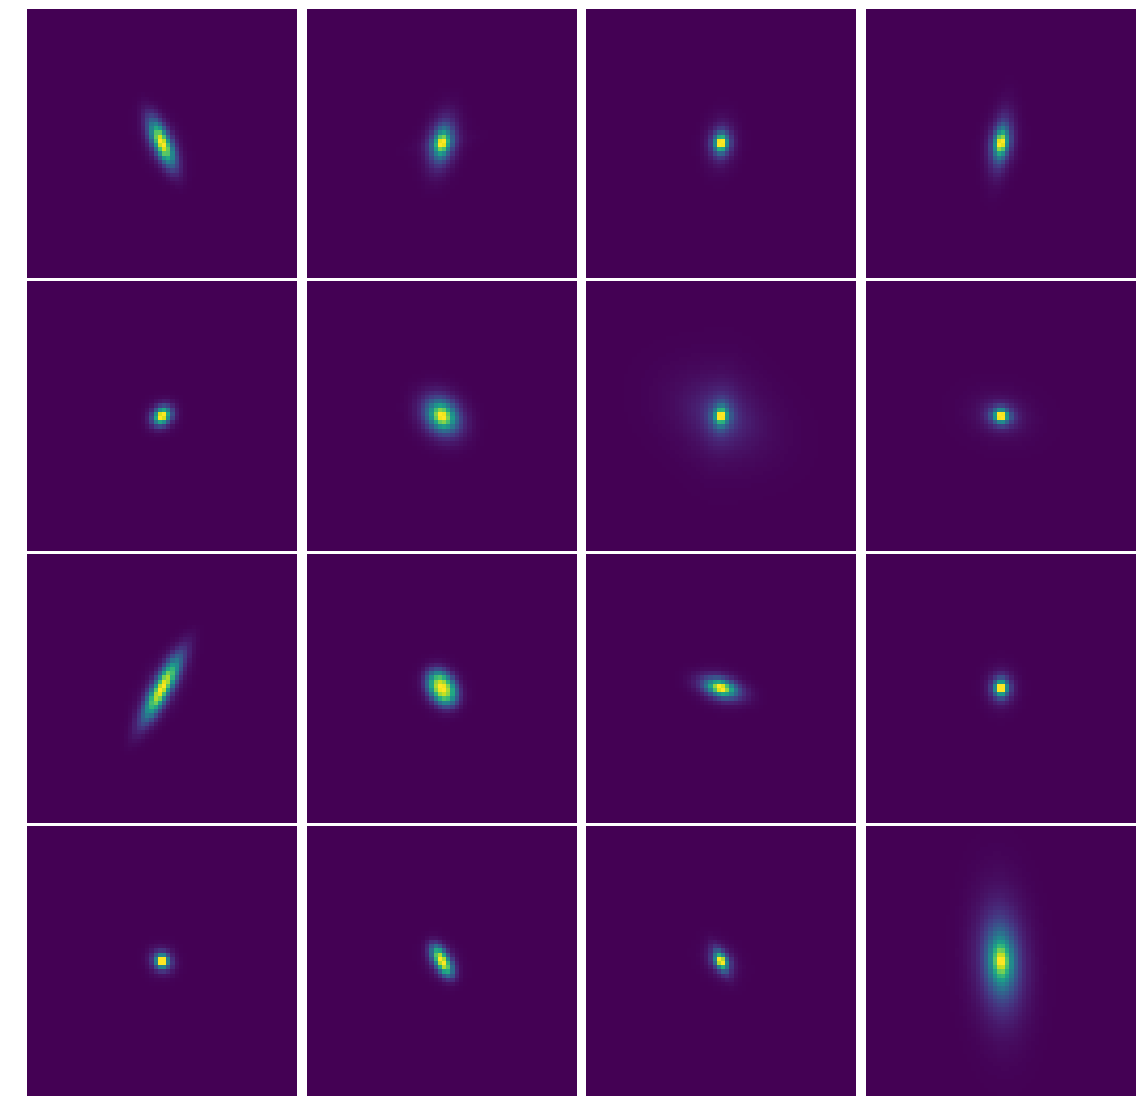

In [56]:
N_plot = 4
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

for i in range(N_plot):
    for j in range(N_plot):
        axes[i,j].imshow(img_cube_list[i*N_plot+j][0][3].reshape(64,64))     
        axes[i,j].axis('off')

filtre : 0
filtre : 1
filtre : 2
filtre : 3
filtre : 4
844.029052734375
noise = galsim.PoissonNoise(sky_level=1578)
878.0
filtre : 5
11011.455078125
noise = galsim.PoissonNoise(sky_level=15931)
11046.0
filtre : 6
19041.19921875
noise = galsim.PoissonNoise(sky_level=35504)
19100.0
filtre : 7
17784.22265625
noise = galsim.PoissonNoise(sky_level=50850)
18180.0
filtre : 8
14432.4384765625
noise = galsim.PoissonNoise(sky_level=79123)
14249.0
filtre : 9
7470.9560546875
noise = galsim.PoissonNoise(sky_level=90846)
7372.0


(-0.5, 63.5, 63.5, -0.5)

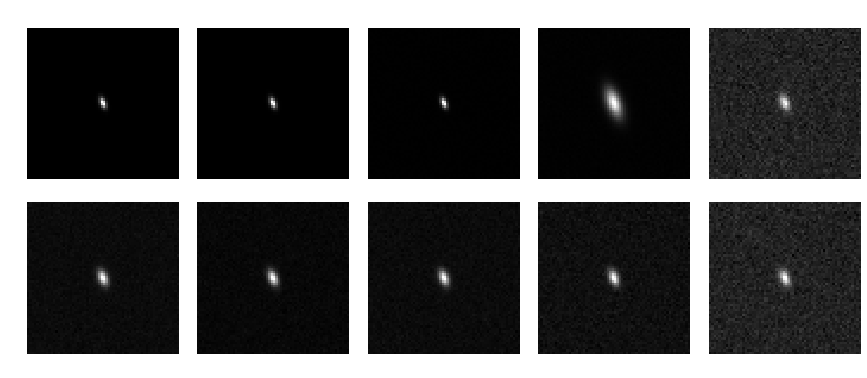

In [13]:
#N_plot = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(wspace=.1, hspace=.15)

noiseless, noisy, redshift = Gal_generator_noisy(cosmos_cat)
axes[0,0].imshow(noisy.reshape(10,stamp_size,stamp_size)[0], cmap='gray') 
axes[0,1].imshow(noisy.reshape(10,stamp_size,stamp_size)[1], cmap='gray') 
axes[0,2].imshow(noisy.reshape(10,stamp_size,stamp_size)[2], cmap='gray') 
axes[0,3].imshow(noisy.reshape(10,stamp_size,stamp_size)[3], cmap='gray') 
axes[0,4].imshow(noisy.reshape(10,stamp_size,stamp_size)[4], cmap='gray') 
axes[1,0].imshow(noisy.reshape(10,stamp_size,stamp_size)[5], cmap='gray') 
axes[1,1].imshow(noisy.reshape(10,stamp_size,stamp_size)[6], cmap='gray') 
axes[1,2].imshow(noisy.reshape(10,stamp_size,stamp_size)[7], cmap='gray') 
axes[1,3].imshow(noisy.reshape(10,stamp_size,stamp_size)[8], cmap='gray') 
axes[1,4].imshow(noisy.reshape(10,stamp_size,stamp_size)[9], cmap='gray') 
axes[0,0].set_title('Y', fontsize=20, color = "w")
axes[0,1].set_title('J', fontsize=20, color = "w")
axes[0,2].set_title('H', fontsize=20, color = "w")
axes[0,3].set_title('VIS', fontsize=20, color = "w")
axes[0,4].set_title('u', fontsize=20, color = "w")
axes[1,0].set_title('g', fontsize=20, color = "w")
axes[1,1].set_title('r', fontsize=20, color = "w")
axes[1,2].set_title('i', fontsize=20, color = "w")
axes[1,3].set_title('z', fontsize=20, color = "w")
axes[1,4].set_title('y', fontsize=20, color = "w")
axes[0,0].axis('off')
axes[0,1].axis('off')
axes[0,2].axis('off')
axes[0,3].axis('off')
axes[0,4].axis('off')
axes[1,0].axis('off')
axes[1,1].axis('off')
axes[1,2].axis('off')
axes[1,3].axis('off')
axes[1,4].axis('off')


(-0.5, 63.5, 63.5, -0.5)

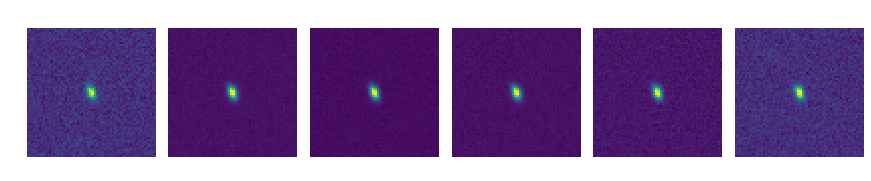

In [14]:
#N_plot = 10
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
fig.subplots_adjust(wspace=.1, hspace=.15)

#noiseless, noisy, redshift = Gal_generator_noisy(cosmos_cat)

axes[0].imshow(noisy.reshape(10,stamp_size,stamp_size)[4]) 
axes[1].imshow(noisy.reshape(10,stamp_size,stamp_size)[5]) 
axes[2].imshow(noisy.reshape(10,stamp_size,stamp_size)[6]) 
axes[3].imshow(noisy.reshape(10,stamp_size,stamp_size)[7]) 
axes[4].imshow(noisy.reshape(10,stamp_size,stamp_size)[8]) 
axes[5].imshow(noisy.reshape(10,stamp_size,stamp_size)[9]) 
axes[0].set_title('u', fontsize=20, color = "w")
axes[1].set_title('g', fontsize=20, color = "w")
axes[2].set_title('r', fontsize=20, color = "w")
axes[3].set_title('i', fontsize=20, color = "w")
axes[4].set_title('z', fontsize=20, color = "w")
axes[5].set_title('y', fontsize=20, color = "w")
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')
axes[4].axis('off')
axes[5].axis('off')

In [8]:
print(input_vae.shape)

(10, 64, 64)


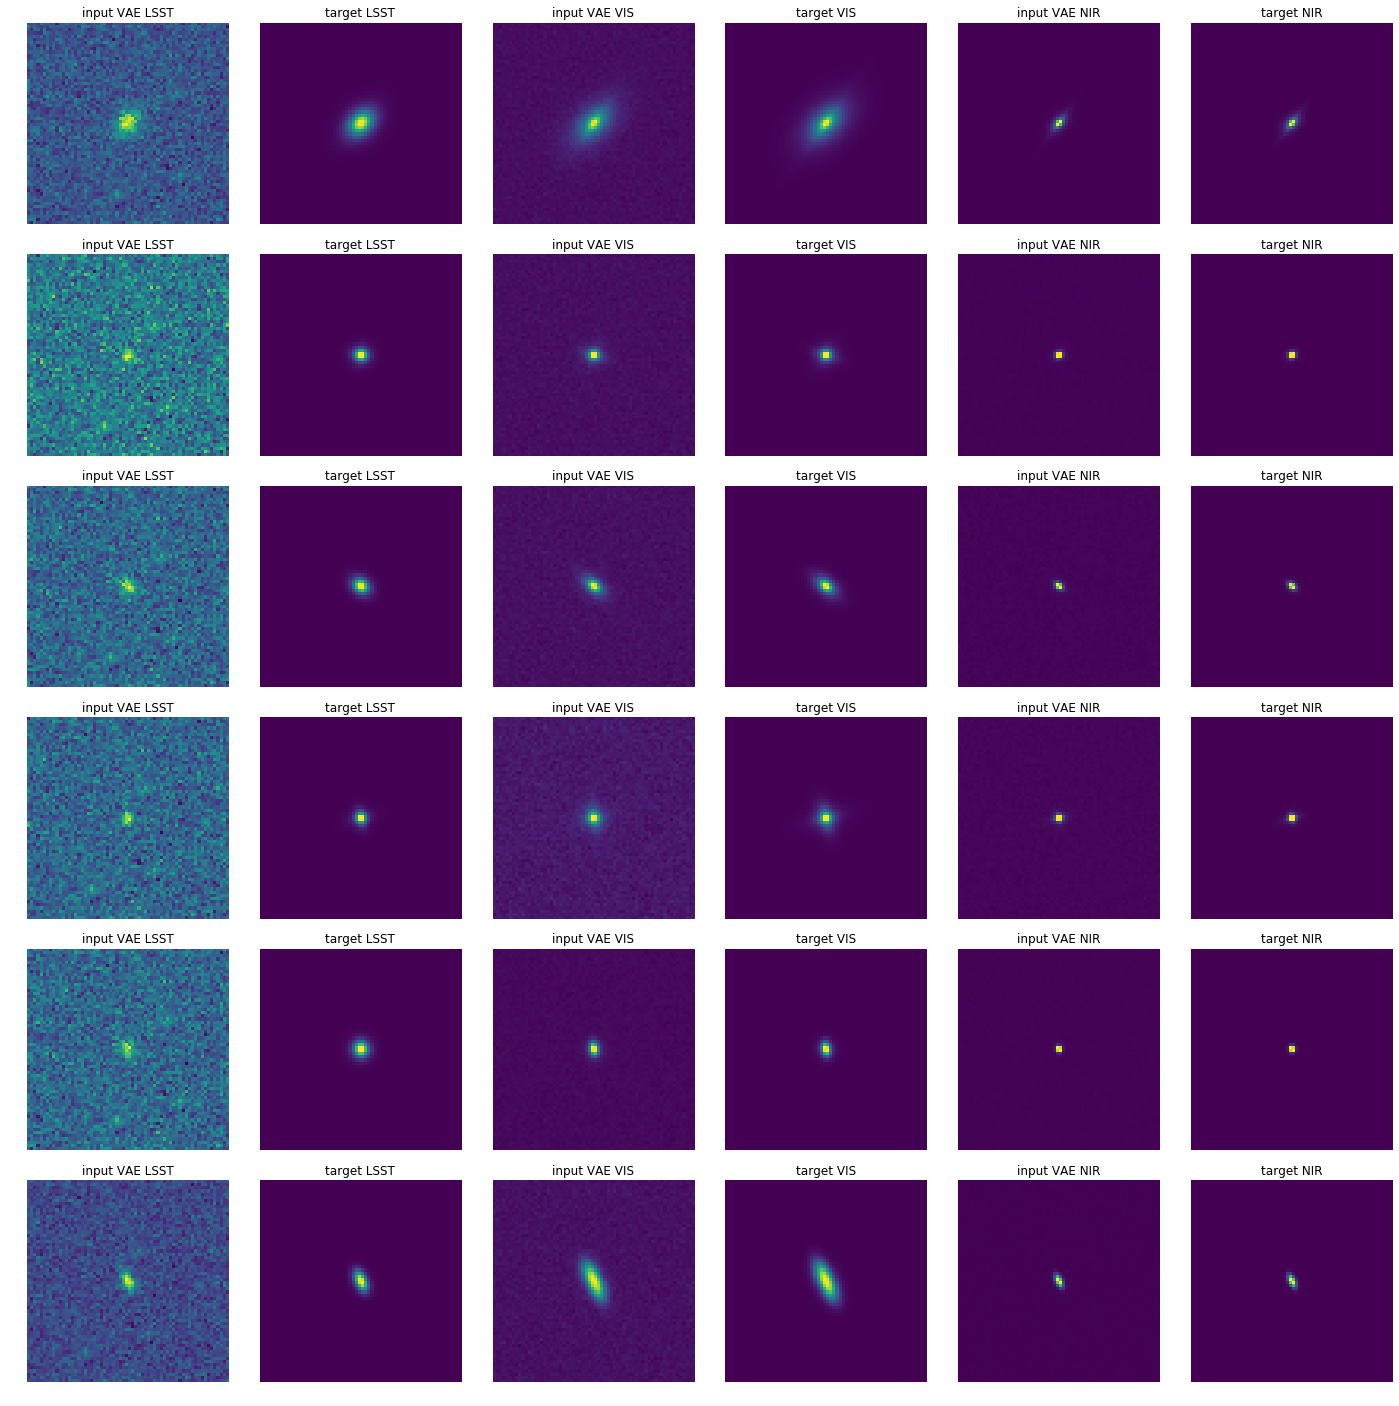

In [9]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,6):
        input_vae_no_noise, input_vae,z = Gal_generator_noisy(cosmos_cat)
        axes[i,j].imshow(input_vae[6])#input_vae
        axes[i,j+1].imshow(input_vae_no_noise[6])#output_vae
        axes[i,j+2].imshow(input_vae[3])#input_vae
        axes[i,j+3].imshow(input_vae_no_noise[3])#output_vae
        axes[i,j+4].imshow(input_vae[1])#input_vae
        axes[i,j+5].imshow(input_vae_no_noise[1])#output_vae
        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE LSST')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('target LSST')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('input VAE VIS')
        axes[i,j+3].axis('off')
        axes[i,j+3].set_title('target VIS')
        axes[i,j+4].axis('off')
        axes[i,j+4].set_title('input VAE NIR')
        axes[i,j+5].axis('off')
        axes[i,j+5].set_title('target NIR')

In [57]:
a = np.load('/sps/lsst/users/barcelin/data/single/v7/galaxies_COSMOS_0_v3.npy')

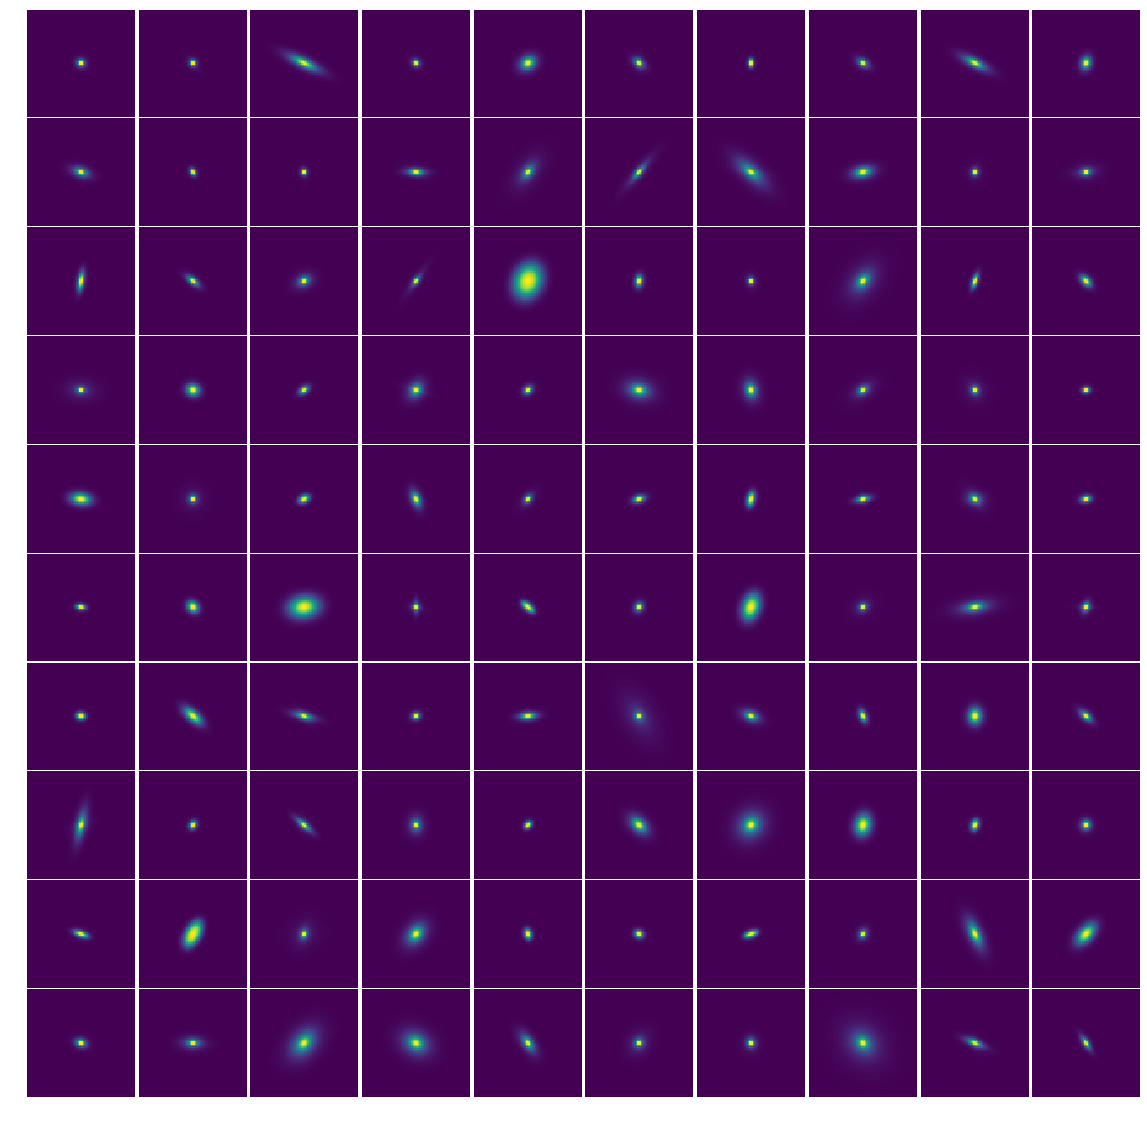

In [59]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

for i in range(N_plot):
    for j in range(N_plot):
        axes[i,j].imshow(a[i*N_plot+j][0][3].reshape(64,64))     
        axes[i,j].axis('off')

[83 10 24 86 42  2 47 21 78 53 67 27 40 45 69 58 39 75 38 26 56 33 94 44
 74 55 88 19 54 28 11 18 84 95 52 96 68 71 22  4 81 66 80 34  7 50 30 97
 25 51]
83
47
40
38
74
11
68
80


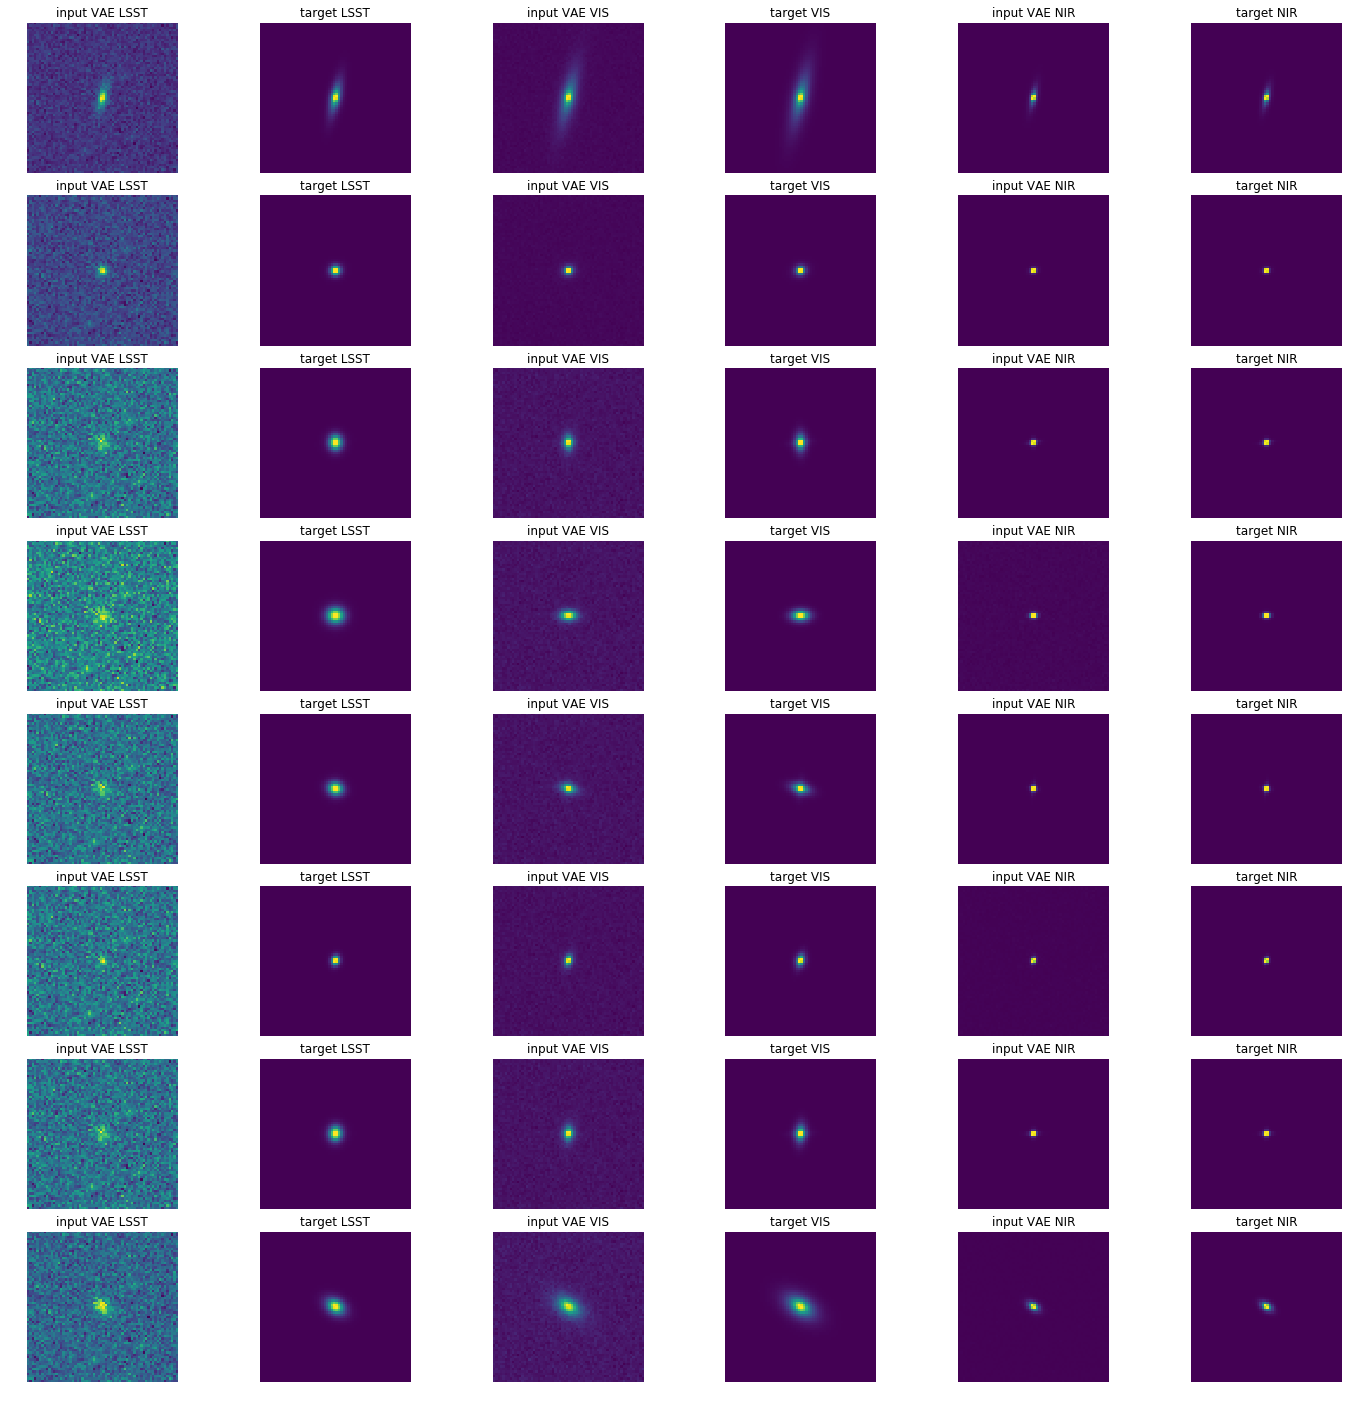

In [11]:
N_plot = 6
fig, axes = plt.subplots(8, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(99, size=50, replace=False)
print(indices)
for i in range(8):
    for j in range(0,N_plot,6):
        print(indices[i*N_plot+j])
        #input_vae_no_noise, input_vae,z = Gal_generator_noisy(cosmos_cat)
        axes[i,j].imshow(a[indices[i*N_plot+j]][1][6])#input_vae
        axes[i,j+1].imshow(a[indices[i*N_plot+j]][0][6])#output_vae
        axes[i,j+2].imshow(a[indices[i*N_plot+j]][1][3])#input_vae
        axes[i,j+3].imshow(a[indices[i*N_plot+j]][0][3])#output_vae
        axes[i,j+4].imshow(a[indices[i*N_plot+j]][1][1])#input_vae
        axes[i,j+5].imshow(a[indices[i*N_plot+j]][0][1])#output_vae
        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE LSST')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('target LSST')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('input VAE VIS')
        axes[i,j+3].axis('off')
        axes[i,j+3].set_title('target VIS')
        axes[i,j+4].axis('off')
        axes[i,j+4].set_title('input VAE NIR')
        axes[i,j+5].axis('off')
        axes[i,j+5].set_title('target NIR')

In [ ]:
class BatchGenerator_lsst_r_band_process_cyrille(keras.utils.Sequence):
    def __init__(self, list_of_samples,total_sample_size, batch_size, training_or_validation):
        self.total_sample_size = total_sample_size
        self.batch_size = batch_size
        self.list_of_samples = list_of_samples
        self.path = random.choice(self.list_of_samples)
        print(self.path)
        self.training_or_validation = training_or_validation
        
        self.x = np.empty([self.batch_size,64,64], dtype='float32')  
        self.y = np.empty([self.batch_size,64,64], dtype='float32')  
        
        self.liste = np.load(self.path, mmap_mode = 'c')
        self.r = 0
        
    def __len__(self):
        return int(float(self.total_sample_size) / float(self.batch_size))      

    def on_epoch_end(self):
        path = random.choice(self.list_of_samples)
        print(path)
        self.liste = np.load(path, mmap_mode = 'c')
        self.r = 0
        
    def __getitem__(self, idx):
        if (self.training_or_validation == 'training'):
            #print('training')
            self.r = np.random.choice(180000-self.batch_size, replace=False)
            if (self.r <=39900):
                #print('liste 1')
                self.liste = np.load(self.list_of_samples[0], mmap_mode = 'c')
                self.x = self.liste[self.r:self.r+self.batch_size,1,6]
                self.y = self.liste[self.r:self.r+self.batch_size,0,6]
            else:
                if (self.r <=79900):
                    #print('liste 2')
                    self.r -= 40000
                    if (self.r >=100):
                        self.liste = np.load(self.list_of_samples[1], mmap_mode = 'c')
                        self.x = self.liste[self.r:self.r+self.batch_size,1,6]
                        self.y = self.liste[self.r:self.r+self.batch_size,0,6]
                    #self.j +=self.batch_size
                else:
                    if (self.r <=119900):
                        #print('liste 3')
                        self.r -= 80000
                        if (self.r >=100):
                            self.liste = np.load(self.list_of_samples[2], mmap_mode = 'c')
                            self.x = self.liste[self.r:self.r+self.batch_size,1,6]
                            self.y = self.liste[self.r:self.r+self.batch_size,0,6]
                    else:
                        if (self.r <=159900):
                            self.r -= 120000
                            #print('liste 4')
                            if (self.r >=100):
                                self.liste = np.load(self.list_of_samples[3], mmap_mode = 'c')
                                self.x = self.liste[self.r:self.r+self.batch_size,1,6]
                                self.y = self.liste[self.r:self.r+self.batch_size,0,6]
                        else:
                            self.r -= 180000
                            #print('liste 5')
                            if (self.r >=100):
                                self.liste = np.load(self.list_of_samples[4], mmap_mode = 'c')
                                self.x = self.liste[self.r:self.r+self.batch_size,1,6]
                                self.y = self.liste[self.r:self.r+self.batch_size,0,6]
        else:
            self.r = np.random.choice(20000-self.batch_size, replace=False)
            self.liste = np.load(self.list_of_samples[4], mmap_mode = 'c')

            self.x = self.liste[20000+self.r:20000+self.r+self.batch_size,1,6]
            self.y = self.liste[20000+self.r:20000+self.r+self.batch_size,0,6]

        # Apply a random rotation to the galaxy to do data augmentation
        #random_degree = random.uniform(0, 180)
        #sk.transform.rotate(self.y, random_degree)
        
        #for i in range(10):
        #plop = np.sinh(np.mean(np.arcsinh(np.max(self.y[:,:,:], axis=(1,2)))))
        #self.x[:,:,:] = np.tanh(np.arcsinh(self.x[:,:,:] / (5*plop)))
        #self.y[:,:,:] = np.tanh(np.arcsinh(self.y[:,:,:] / (5*plop)))
        I = np.mean(self.y, keepdims=True)
        #print(I)
        beta = 1000.
        self.y = np.tanh(self.y * np.arcsinh(I/beta)/I)

        #print(plop, self.x.shape)
        # horizontal flip : flipping the image array of pixels
        rand = np.random.randint(2)
        #print(rand)
        if rand == 1: 
          #  print("oui")
            self.x = np.flipud(self.x)
            self.y = np.flipud(self.y)
        
        return self.y.reshape((self.batch_size,64,64)), self.y.reshape((self.batch_size,64,64))

In [ ]:
import random

In [ ]:
list_of_samples=['/sps/lsst/users/barcelin/data/single/galaxies_COSMOS_1_v5_test.npy',
                 '/sps/lsst/users/barcelin/data/single/galaxies_COSMOS_2_v5_test.npy',
                 '/sps/lsst/users/barcelin/data/single/galaxies_COSMOS_3_v5_test.npy',
                 '/sps/lsst/users/barcelin/data/single/galaxies_COSMOS_4_v5_test.npy',
                 '/sps/lsst/users/barcelin/data/single/galaxies_COSMOS_5_v5_test.npy',
                ]


batch_size = 100
training_generator = BatchGenerator_lsst_r_band_process_cyrille(list_of_samples,total_sample_size=180000, batch_size= batch_size, training_or_validation = 'training')
validation_generator = BatchGenerator_lsst_r_band_process_cyrille(list_of_samples,total_sample_size=20000, batch_size= batch_size, training_or_validation = 'validation')



In [ ]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):
        input_vae, input_vae_no_noise = training_generator.__getitem__(22)
        axes[i,j].imshow(input_vae[6])#input_vae
        axes[i,j+1].imshow(input_vae_no_noise[6])#output_vae
        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE LSST')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('target LSST')

In [ ]:
import matplotlib.pyplot as plt
import keras
import sys
import os
import logging
#import galsim
import random
import cmath as cm
import math
#from keras import backend as K
from keras import metrics
#from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, Flatten,  Reshape, UpSampling2D, Cropping2D, Conv2DTranspose, PReLU, Concatenate, Lambda, BatchNormalization
from keras.models import Model, Sequential
from scipy.stats import norm

#from vae_callbacks import PlotLearning
#from generator import BatchGenerator_lsst_r_band_preprocess_data_augm
#from vae_model import vae_conv_model

from keras import backend as K
#import tensorflow.keras.backend as K
from keras import metrics
from keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, Flatten,  Reshape, UpSampling2D, Cropping2D, Conv2DTranspose, PReLU, Concatenate, Lambda, BatchNormalization
from keras.models import Model, Sequential


#import vae, layers

#import tensorflow_probability as tfp




############# VAE Convolutional model - Cyrille
# Parameters
input_shape = 64*64
#original_dim = np.prod(input_shape)
latent_dim = 10

hidden_dim = 256
filters = [32,64,128,256]
kernels = [3,3,3,3]

batch_size = 100
original_dim = 64*64

intermediate_dim = 2000
epochs = 10
epsilon_std = 1.0


sky_level_pixel = [932.29278055877,
 967.2820009773891,
 1728.0864968344283,
 352.64353501116443,
 15.784141110613987,
 159.3199784077823,
 355.0482050297898,
 508.5047090068849,
 791.23302146216,
 908.4632199540499]

N_exposures = [1,1,1,1,100,100,100,100,100,100]

In [ ]:
def build_encoder(latent_dim, hidden_dim, filters, kernels, conv_activation='softplus', dense_activation='softplus'):
    input_layer = Input(shape=(64,64))
    r = Reshape((64,64,1))(input_layer)
    h = BatchNormalization()(r)
    for i in range(len(filters)):
        h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same')(h)
        h = PReLU()(h)
        h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same', strides=(2,2))(h)
        h = PReLU()(h)
    h = Flatten()(h)
    h = Dense(hidden_dim, activation=dense_activation)(h)
    h = PReLU()(h)
    mu = Dense(latent_dim)(h)
    sigma = Dense(latent_dim, activation='softplus')(h)
    return Model(input_layer, [mu, sigma])

encoder = build_encoder(latent_dim, hidden_dim, filters, kernels)


In [ ]:
encoder.summary()

In [ ]:
def build_decoder(input_shape, latent_dim, hidden_dim, filters, kernels, conv_activation='softplus', dense_activation='softplus'):
    input_layer = Input(shape=(latent_dim,))
    h = Dense(hidden_dim, activation=dense_activation)(input_layer)
    h = PReLU()(h)
    w = int(np.ceil(input_shape[0]/2**(len(filters))))
    h = Dense(w*w*filters[-1], activation=dense_activation)(h)
    h = PReLU()(h)
    h = Reshape((w,w,filters[-1]))(h)
    for i in range(len(filters)-1,-1,-1):
        h = Conv2DTranspose(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same', strides=(2,2))(h)
        h = PReLU()(h)
        h = Conv2DTranspose(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same')(h)
        h = PReLU()(h)
    h = Conv2D(input_shape[-1], (3,3), activation='sigmoid', padding='same')(h)
    cropping = int(h.get_shape()[1]-input_shape[0])
    if cropping>0:
        print('in cropping')
        if cropping % 2 == 0:
            h = Cropping2D(cropping/2)(h)
        else:
            h = Cropping2D(((cropping//2,cropping//2+1),(cropping//2,cropping//2+1)))(h)
    if (input_shape ==(64,64,1)):
        h = Reshape((64,64))(h)
        
    return Model(input_layer, h)

decoder = build_decoder((64,64,1), latent_dim, hidden_dim, filters, kernels, conv_activation=None, dense_activation=None)


In [ ]:
decoder.summary()

In [ ]:
input_vae = Input(shape=(64,64))
output_encoder = encoder(input_vae)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))(output_encoder)

vae = Model(input_vae, decoder(z))

In [ ]:
vae.summary()

In [ ]:
def vae_loss(x, x_decoded_mean):
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = original_dim*metrics.binary_crossentropy(x, x_decoded_mean)#gaussian_poissonian_loss(x, x_decoded_mean)
    kl_loss = - .0001 * K.sum(1 + output_encoder[1] - K.square(output_encoder[0]) - K.exp(output_encoder[1]), axis=-1)

    return K.mean(xent_loss + kl_loss)

vae.compile('adam', loss=vae_loss, metrics=['mse'])

In [ ]:
K.set_value(vae.optimizer.lr, 0.0001)

In [ ]:
######## Train the VAE
hist = vae.fit_generator(training_generator,
        epochs=100,
        steps_per_epoch=10,
        verbose=1,
        shuffle = True,
                         
        validation_steps =10,
        validation_data=validation_generator)